In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
vehicle_image_location=glob.glob('./data/vehicles/*/*.png')
non_vehicle_image_location=glob.glob('./data/non-vehicles/*/*.png')

vehicle_images=[]
non_vehicle_images=[]

for fname in vehicle_image_location:
    vehicle=mpimg.imread(fname)
    vehicle_images.append(vehicle)

for fname in non_vehicle_image_location:
    non_vehicle=mpimg.imread(fname)
    non_vehicle_images.append(non_vehicle)
    
print('Number of images in vehicle dataset:',len(vehicle_images))
print()
print('Number of images in Non-vehicle dataset:',len(non_vehicle_images))

Number of images in vehicle dataset: 8792

Number of images in Non-vehicle dataset: 8968


Color Histogram Features
===

In [41]:
def color_hist(img,nbins=32,bin_range=(0,256),vis=False):
    channel_1_hist=np.histogram(img[:,:,0],nbins,bin_range)
    channel_2_hist=np.histogram(img[:,:,1],nbins,bin_range)
    channel_3_hist=np.histogram(img[:,:,2],nbins,bin_range)
    
    bin_edges=channel_1_hist[1]
    bin_centers=(bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    
    color_hist_features=np.concatenate((channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]))
    if vis==True:
        return channel_1_hist, channel_2_hist, channel_3_hist, bin_centers
    else:
        return color_hist_features




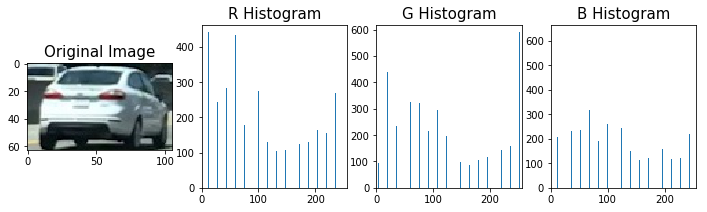

In [57]:
#Visualization of Color Histogram features
random_ind=np.random.randint(0,len(vehicle_images))
image=mpimg.imread('./examples/cutout1.jpg')
rh, gh, bh, bincen = color_hist(image, nbins=32,vis=True)

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3));
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Original Image', fontsize=15)
    plt.subplot(142)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram', fontsize=15);
    plt.subplot(143)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram', fontsize=15);
    plt.subplot(144)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram', fontsize=15);

    plt.savefig('output_images/color_hist_vis.png', 
                bbox_inches="tight")
else:
    print('Your function is returning None for at least one variable...')

Binary Spatial Features
===

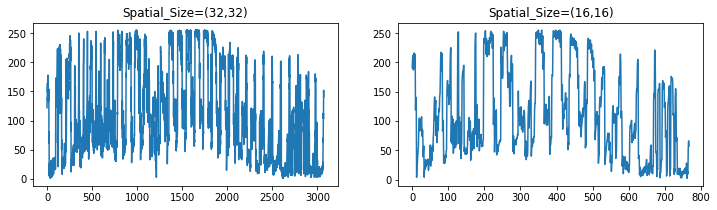

In [64]:
def bin_spatial(img,size=(32,32)):
    
    binary_features=cv2.resize(img,size).ravel()
    
    return binary_features

#Visualization

fig,axs=plt.subplots(1,2,figsize=(12,3))

ax=axs.ravel() 

ax[0].plot(bin_spatial(image,size=(32,32)))
ax[0].set_title('Spatial_Size=(32,32)')
ax[1].plot(bin_spatial(image,size=(16,16)))
ax[1].set_title('Spatial_Size=(16,16)')


  

    

HOG features
===

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return hog_features

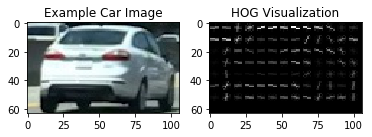

In [65]:
#Visualize HOG features
features, hog_image = get_hog_features(image, orient= 8,pix_per_cell= 8, cell_per_block= 2,vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [7]:
def extract_features(imgs,cspace='RGB',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        binary_features=bin_spatial(feature_image,size=(spatial,spatial))
        hist_features=color_hist(feature_image,bins)
        
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((binary_features,hist_features,hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features


In [8]:
spatial=16
bins=16
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

Train Classifier
====

In [9]:
t=time.time()
car_features = extract_features(vehicle_images,cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(non_vehicle_images,cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

107.08 Seconds to extract HOG features...
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
3.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
For these 10 labels:  [1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
0.003 Seconds to predict 10 labels with SVC


Hog Subsampling windows
===

In [10]:
#X_scaler = StandardScaler().fit(X_train)
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,spatial_size=spatial,hist_bins=bins,show_rects=False):
    bbox_list=[]
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
           ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
    #ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=(spatial_size,spatial_size))
            histogram_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, histogram_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_rects:#Inspired from Jeremy Shannon work
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bbox_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color: #Inspired form Jeremy Shannon Code
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [11]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img





Visualize different Scales
====

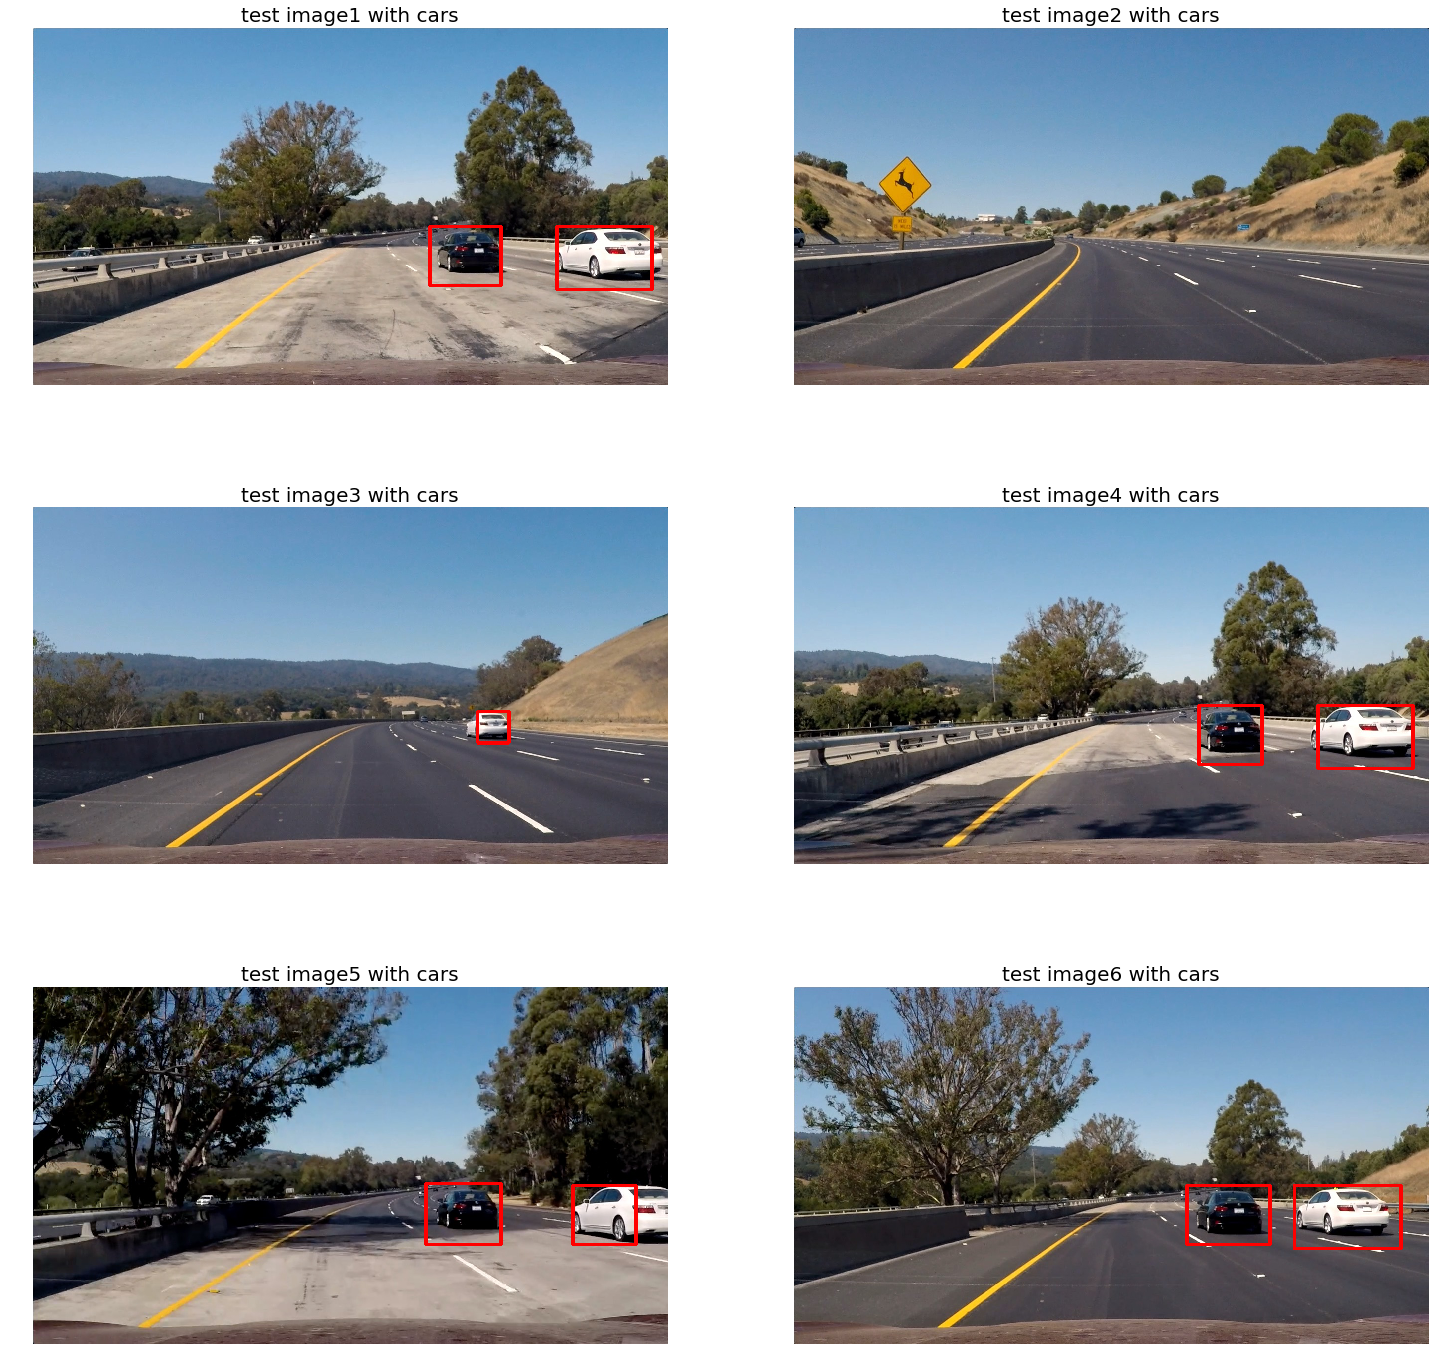

In [97]:
spatial=16
bins=16
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


images=glob.glob('./test_images/*.jpg')
fig,axs=plt.subplots(3,2,figsize=(25,25))
ax=axs.ravel()
for idx,file in enumerate(images):
    image=mpimg.imread(file)
    img = image.astype(np.float32)/255
    
    
    boxes=[]

    ystart = 380
    ystop = 550
    scale = 1.0

    out1=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out1)

    ystart = 400
    ystop = 600
    scale = 1.5

    out2=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out2)


    ystart = 400
    ystop = 656
    scale = 2.0

    out3=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out3)

    rectangles = [item for sublist in boxes for item in sublist] #From Jeremy Shannon Work
    rectangles= [ elem for elem in rectangles if elem[0][0] >= 600]
    #Assuming that the car is in the left lane

    #out_img=draw_boxes(image,rectangles,color='random')
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap=add_heat(heat,rectangles)
    
    heatmap=apply_threshold(heatmap,2)
    heatmap = np.clip(heatmap, 0, 255)
    labels=label(heatmap)
    out_img=draw_labeled_bboxes(image,labels)
    
    
    ax[idx].imshow(out_img)
    ax[idx].set_title('test image'+str(idx+1)+' with cars',fontsize=20)
    ax[idx].axis('off')
    plt.savefig('output_images/pipeline.png', bbox_inches="tight")



Image pipeline
====

In [98]:
def pipeline(image):
    spatial=16
    bins=16
    cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


    boxes=[]
    rectangles=[]
    
    original_img=np.copy(image)
    img=image.astype(np.float32)/255
  
    ystart = 380
    ystop = 550
    scale = 1.0

    out1=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out1)

    ystart = 400
    ystop = 600
    scale = 1.5

    out2=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out2)


    ystart = 400
    ystop = 656
    scale = 2.0

    out3=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out3)

   



    rectangles = [item for sublist in boxes for item in sublist]

    
    
    rectangles= [ elem for elem in rectangles if elem[0][0] >= 600]
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap=add_heat(heat,rectangles)
    heatmap=apply_threshold(heatmap,2)
    heatmap = np.clip(heatmap, 0, 255)
    labels=label(heatmap)
    out_img=draw_labeled_bboxes(original_img,labels)
    
    
    
    
    return out_img

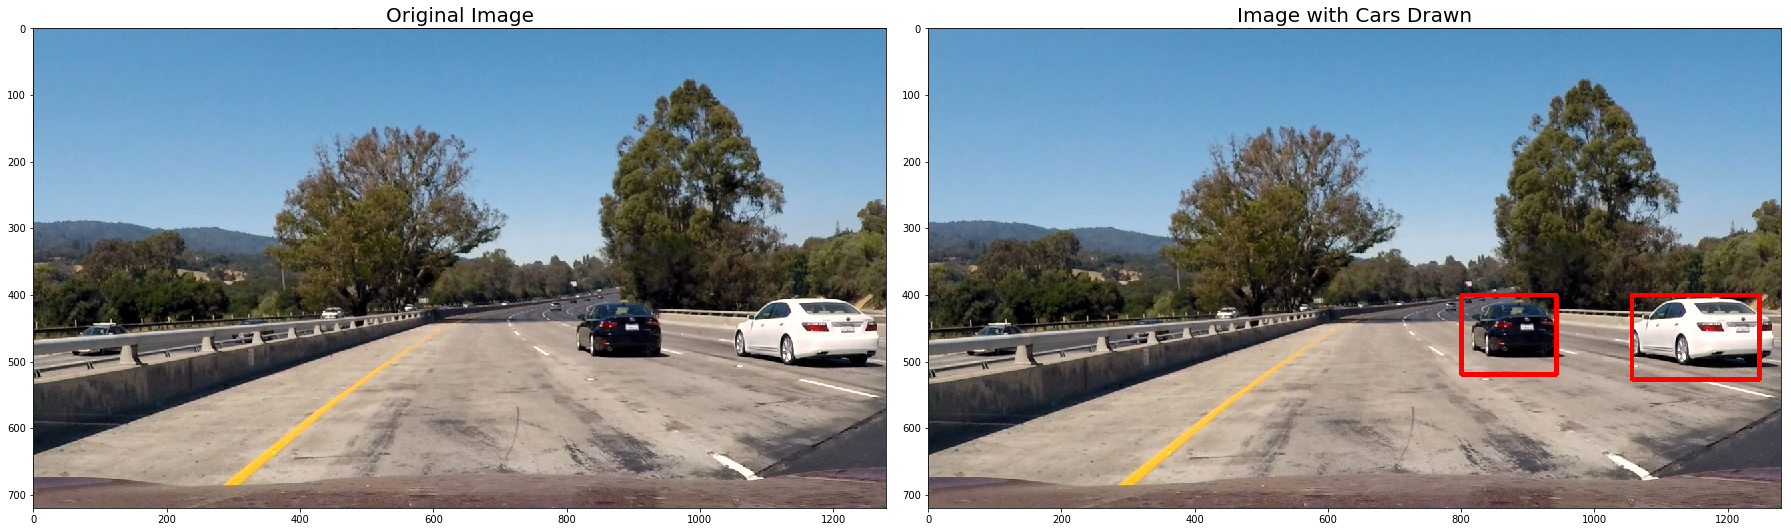

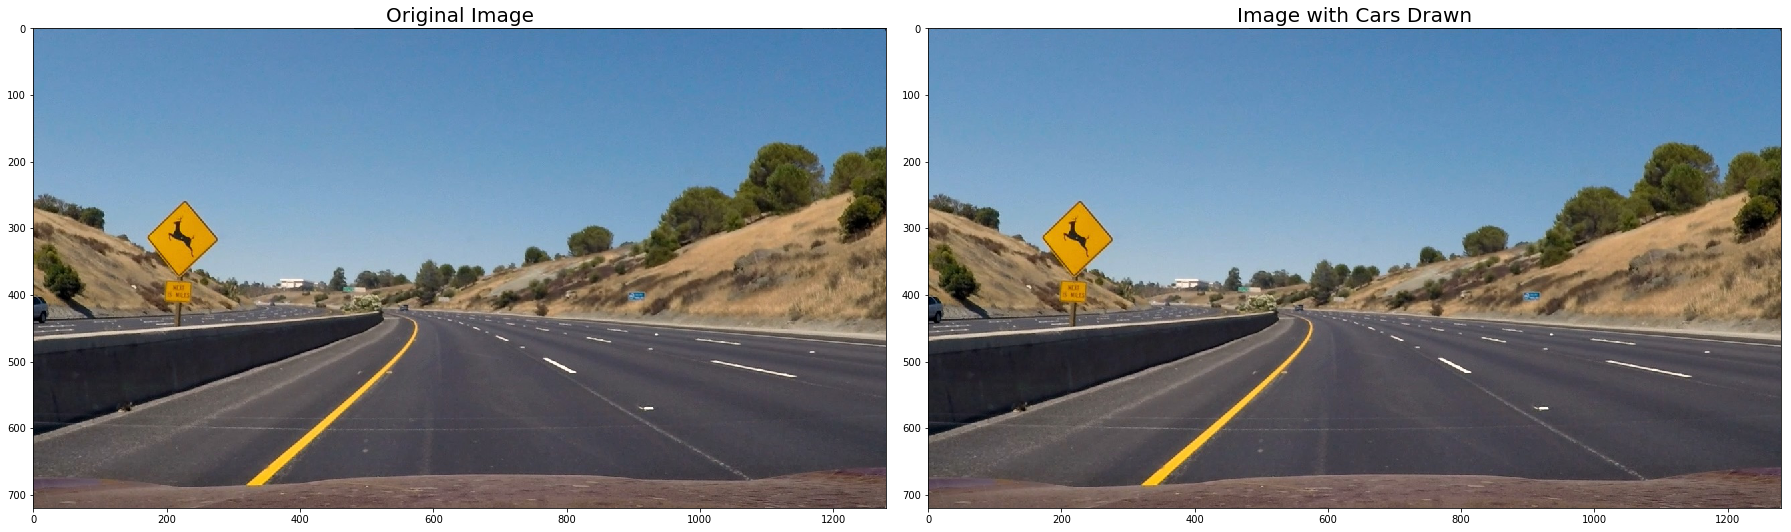

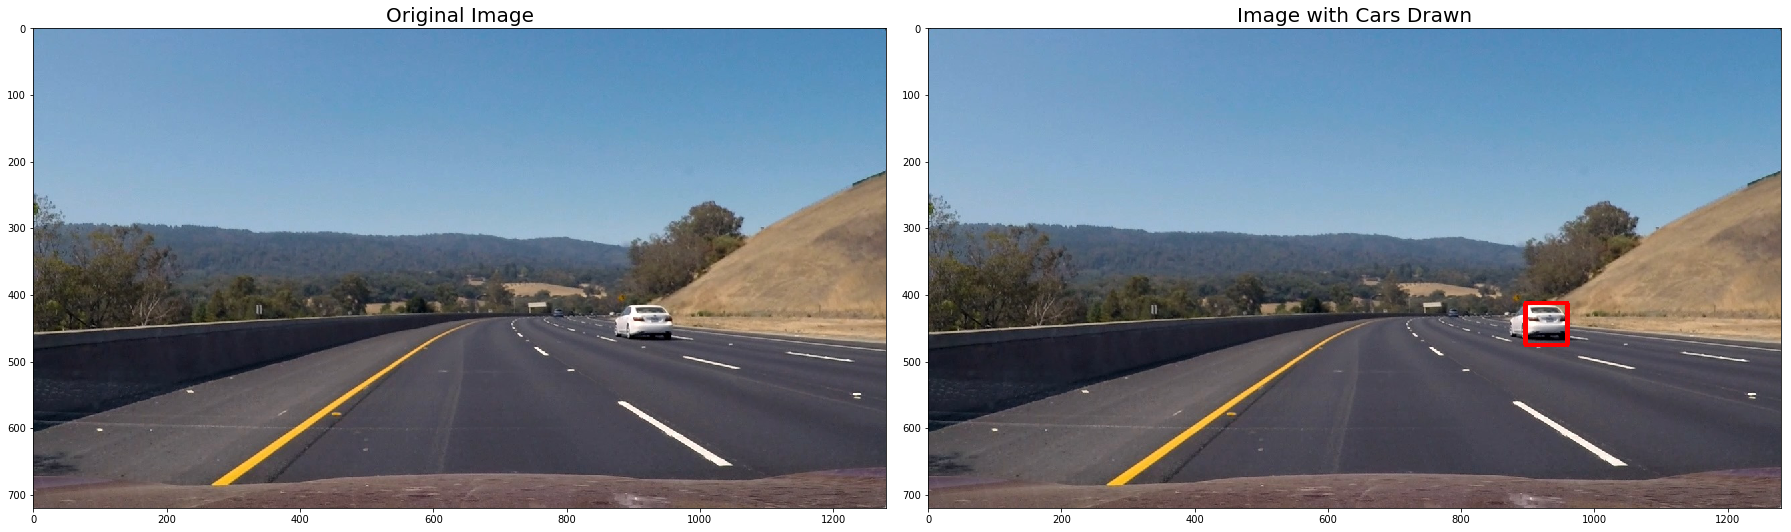

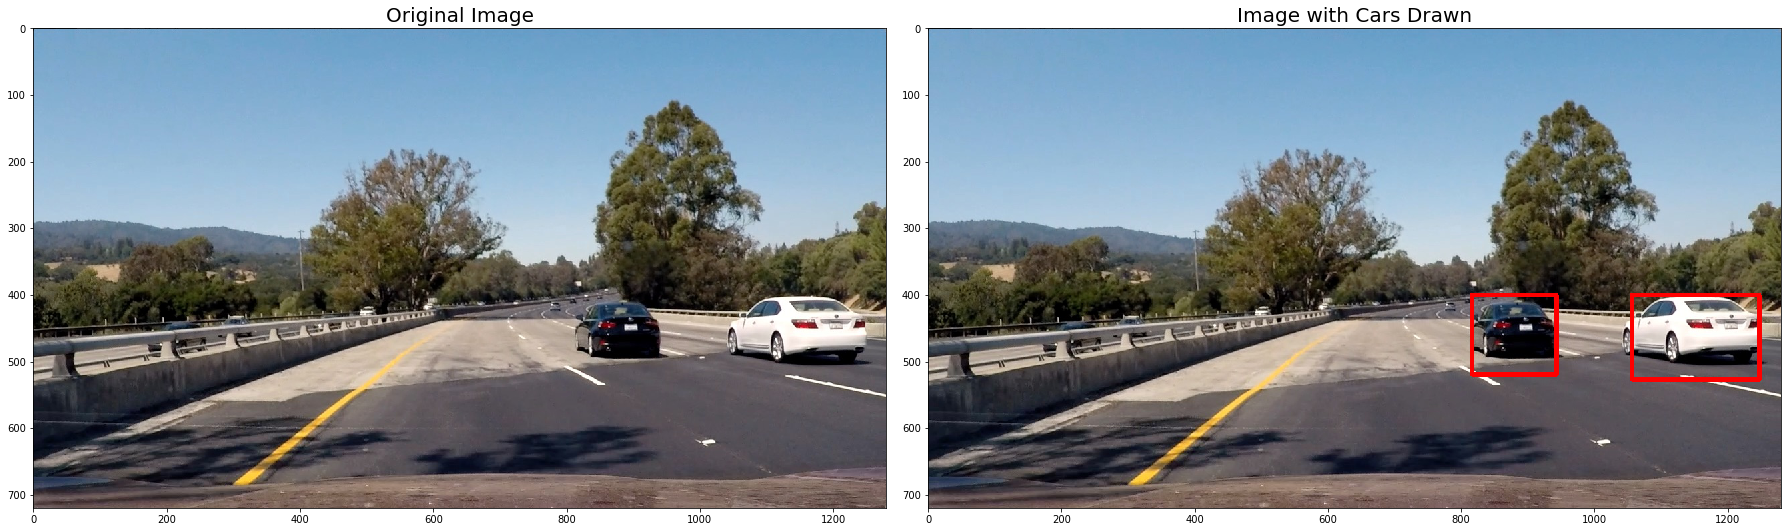

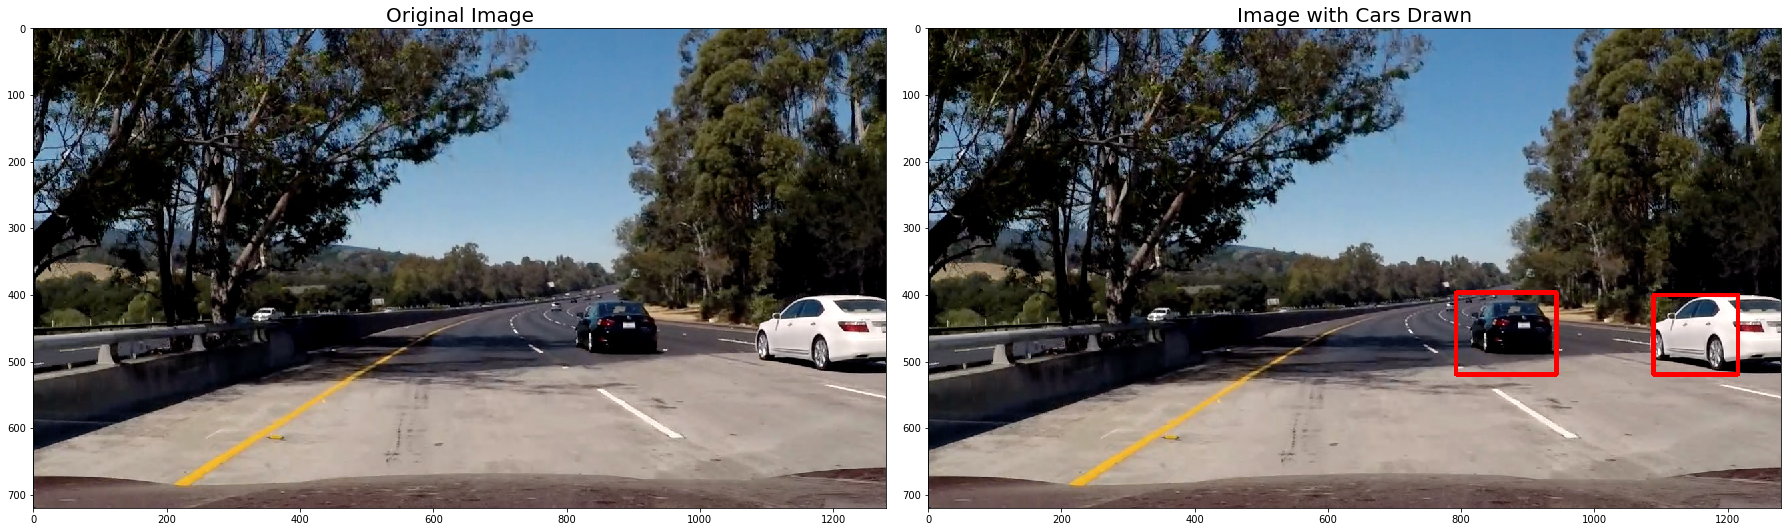

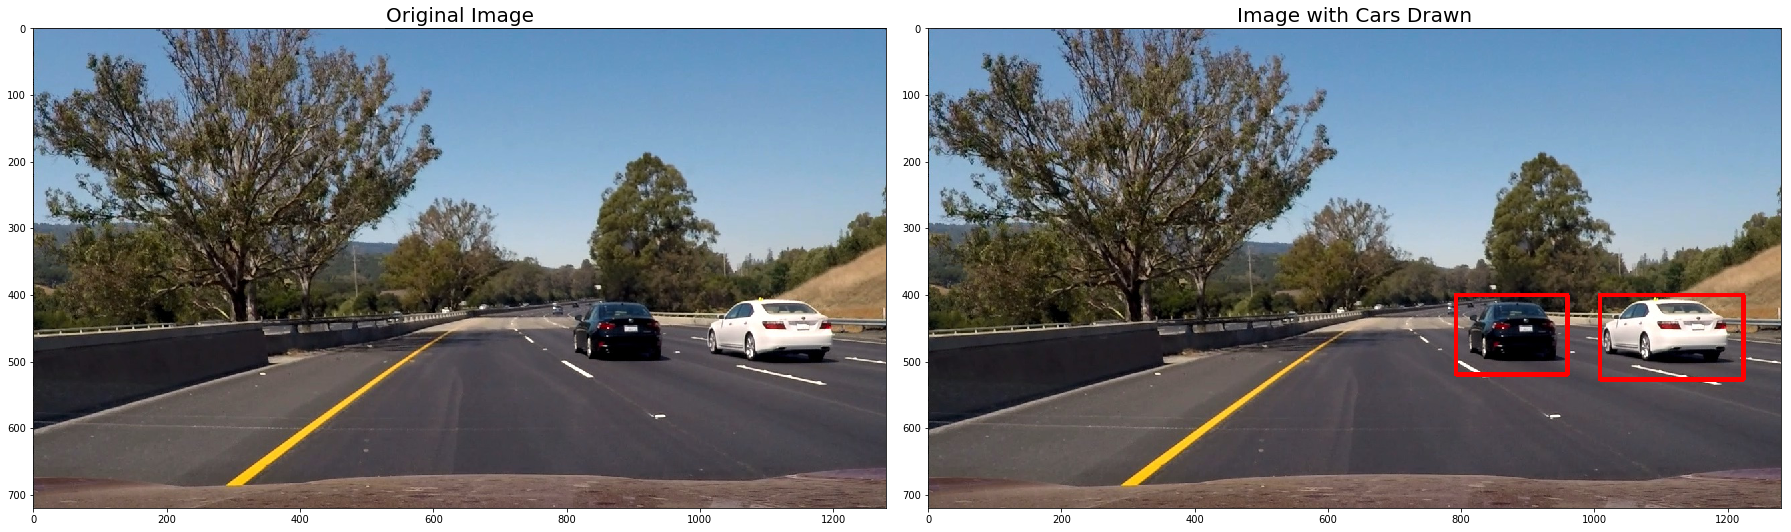

In [99]:
images=glob.glob('./test_images/*.jpg')

for file in images:
    image=mpimg.imread(file)
    
    out=pipeline(image)
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,25))
    fig.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image',fontsize=20)
    ax2.imshow(out)

    ax2.set_title('Image with Cars Drawn',fontsize=20)


In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
test_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████████████████████████████████████████████████████████████████████  | 38/39 [01:01<00:01,  1.62s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 4s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

Video Pipeline
====

In [26]:
#This one is taken from Jeremy Shannon work
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [29]:
def process_video(image):
    spatial=16
    bins=16
    cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


    boxes=[]
    rectangles=[]
    
    original_img=np.copy(image)
    img=image.astype(np.float32)/255
    
    ystart = 380
    ystop = 550
    scale = 1.0

    out1=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out1)

    ystart = 400
    ystop = 600
    scale = 1.5

    out2=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out2)


    ystart = 400
    ystop = 656
    scale = 2.0

    out3=find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,cspace,show_rects=False)
    boxes.append(out3)

    rectangles = [item for sublist in boxes for item in sublist]

    
    
    rectangles= [ elem for elem in rectangles if elem[0][0] >= 600]
   
    if len(rectangles) >0:
        det.add_rects(rectangles)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    for rect_set in det.prev_rects:
        heatmap=add_heat(heatmap,rect_set)
    
    heatmap=apply_threshold(heatmap,1+len(det.prev_rects)//2)
    heatmap = np.clip(heatmap, 0, 255)
    labels=label(heatmap)
    out_img=draw_labeled_bboxes(original_img,labels)
    return out_img

In [30]:
det=Vehicle_Detect()
test_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████▉| 1260/1261 [44:18<00:02,  2.11s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 44min 20s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))